## this model made to reduce false positives and ignore non-english tweets (classify them as non-disaster)

In [5]:
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, 
                            confusion_matrix, precision_recall_curve, 
                            roc_curve, auc)
import matplotlib.pyplot as plt
import re
import string
from langdetect import detect, LangDetectException

In [6]:
# 1. LOAD AND CLEAN JSONL DATA
# ============================================================

def load_jsonl(file_path):
    """
    Load JSONL file and extract relevant fields.
    Keeps only 'text' and 'manual_label', adds 'id'.
    """
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f):
            tweet = json.loads(line)
            cleaned_tweet = {
                'id': idx,
                'text': tweet.get('text', ''),
                'manual_label': tweet.get('manual_label', None)
            }
            data.append(cleaned_tweet)
    return pd.DataFrame(data)

# Load training and testing data
print("Loading training data...")
train_df = load_jsonl('manual_labeled.jsonl')
print(f"Training data loaded: {train_df.shape[0]} tweets")

print("\nLoading testing data...")
test_df = load_jsonl('test_data.jsonl')
print(f"Testing data loaded: {test_df.shape[0]} tweets")

print("\nFirst few rows of training data:")
print(train_df.head())

print("\nClass distribution in training data:")
print(train_df['manual_label'].value_counts())

Loading training data...
Training data loaded: 200 tweets

Loading testing data...
Testing data loaded: 200 tweets

First few rows of training data:
   id                                               text  manual_label
0   0  🌍 Earthquake Alert 🌍\n📍 Location: 67 km E of P...             1
1   1  🌍 Earthquake Alert 🌍\n📍 Location: Sulawesi, In...             1
2   2  Earthquake Report\n\nEarthquake M4.1 has been ...             1
3   3  Magnitude : 5.1\nRegion: *Off East Coast of Ho...             1
4   4  #Earthquake M5.0 | Off East Coast of Honshu, J...             1

Class distribution in training data:
manual_label
1    117
0     83
Name: count, dtype: int64


In [7]:
# 2. LANGUAGE DETECTION
# ============================================================

def detect_language(text):
    """
    Detects the language of the text.
    Returns 'en' for English, other language codes otherwise.
    Returns 'unknown' if detection fails.
    """
    if pd.isna(text) or text.strip() == '':
        return 'unknown'
    
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

# Detect language for all tweets
print("\nDetecting languages...")
train_df['language'] = train_df['text'].apply(detect_language)
test_df['language'] = test_df['text'].apply(detect_language)

# Show language distribution
print("\nLanguage distribution in training data:")
print(train_df['language'].value_counts())

print("\nLanguage distribution in testing data:")
print(test_df['language'].value_counts())

# Filter to only English tweets for training
train_english = train_df[train_df['language'] == 'en'].copy()
print(f"\nFiltered training data to English only: {len(train_english)} tweets (from {len(train_df)})")

# Separate English and non-English test data
test_english = test_df[test_df['language'] == 'en'].copy()
test_non_english = test_df[test_df['language'] != 'en'].copy()
print(f"Test data - English: {len(test_english)}, Non-English: {len(test_non_english)}")



Detecting languages...

Language distribution in training data:
language
en    188
ko      8
es      2
bn      2
Name: count, dtype: int64

Language distribution in testing data:
language
en    188
ja      3
ko      3
de      3
es      2
fi      1
Name: count, dtype: int64

Filtered training data to English only: 188 tweets (from 200)
Test data - English: 188, Non-English: 12


In [8]:
# 3. TEXT PREPROCESSING
# ============================================================

def preprocess_text(text):
    """
    Preprocesses tweet text by:
    - Converting to lowercase
    - Removing URLs
    - Removing mentions (@username)
    - Removing emojis
    - Removing standalone numbers (magnitudes, depths, coordinates)
    - Removing dates and times
    - Removing special characters and punctuation
    - Removing extra whitespace
    - Keeping meaningful labels (location, magnitude, depth, etc.)
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags (keep the word, remove the #)
    text = re.sub(r'#', '', text)
    
    # Remove emojis (comprehensive pattern for all emoji ranges)
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags
        "\U00002702-\U000027B0"  # dingbats
        "\U000024C2-\U0001F251"  # enclosed characters
        "\U0001F900-\U0001F9FF"  # supplemental symbols
        "\U0001FA00-\U0001FAFF"  # extended symbols
        "\U00002500-\U00002BEF"  # additional symbols
        "\U0001F000-\U0001F02F"  # mahjong tiles
        "\U0001F0A0-\U0001F0FF"  # playing cards
        "\U00002300-\U000023FF"  # miscellaneous technical (includes ⏰)
        "\U00002B00-\U00002BFF"  # miscellaneous symbols and arrows
        "\U0000FE00-\U0000FE0F"  # variation selectors
        "\U0001F200-\U0001F2FF"  # enclosed ideographic supplement
        "]+", 
        flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)
    
    # Remove standalone numbers that might be coordinates, magnitudes, depths
    # But keep words with numbers (like "2day" or "gr8")
    text = re.sub(r'\b\d+\.?\d*\b', '', text)
    
    # Remove dates and times (various formats)
    text = re.sub(r'\d{4}-\d{2}-\d{2}', '', text)
    text = re.sub(r'\d{2}:\d{2}:\d{2}', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply preprocessing
print("\nPreprocessing text...")
train_english['cleaned_text'] = train_english['text'].apply(preprocess_text)
test_english['cleaned_text'] = test_english['text'].apply(preprocess_text)

print("\nExample of cleaned training text:")
print(f"Original: {train_english['text'].iloc[0]}")
print(f"Cleaned: {train_english['cleaned_text'].iloc[0]}")

print("\nExample of cleaned testing text:")
print(f"Original: {test_english['text'].iloc[0]}")
print(f"Cleaned: {test_english['cleaned_text'].iloc[0]}")


Preprocessing text...

Example of cleaned training text:
Original: 🌍 Earthquake Alert 🌍
📍 Location: 67 km E of Port Alsworth, Alaska
📏 Magnitude (ml): 2.3
🔽 Depth: 131.50 km
⏰ Time: 2025-10-06 15:08:35 UTC
🔗 Source: USGS
Stay safe!
Cleaned: earthquake alert location km e of port alsworth alaska magnitude ml depth km time utc source usgs stay safe

Example of cleaned testing text:
Original: New earthquake reported: M 5.4 - Drake Passage - 2025-10-10T22:07:47.232Z
Cleaned: new earthquake reported m drake passage 10t22232z


In [9]:
# 4. FEATURE EXTRACTION USING TF-IDF
# ============================================================

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),
    stop_words='english'
)

# Fit and transform training data (English only)
X_train = tfidf.fit_transform(train_english['cleaned_text'])
y_train = train_english['manual_label']

# Transform testing data (English only)
X_test = tfidf.transform(test_english['cleaned_text'])

print(f"\nTF-IDF feature matrix shape (training): {X_train.shape}")
print(f"TF-IDF feature matrix shape (testing - English only): {X_test.shape}")


TF-IDF feature matrix shape (training): (188, 586)
TF-IDF feature matrix shape (testing - English only): (188, 586)


In [10]:
# 5. SPLIT DATA FOR VALIDATION
# ============================================================

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42,
    stratify=y_train
)

print(f"\nTraining set size: {X_train_split.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")


Training set size: 150
Validation set size: 38


In [11]:
# 6. TRAIN LOGISTIC REGRESSION MODEL
# ============================================================

print("\nTraining the model...")
model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    C=1.0
)
model.fit(X_train_split, y_train_split)
print("Model training complete!")


Training the model...
Model training complete!



Optimal Threshold Found: 0.569
  Precision at this threshold: 0.955
  Recall at this threshold: 0.913


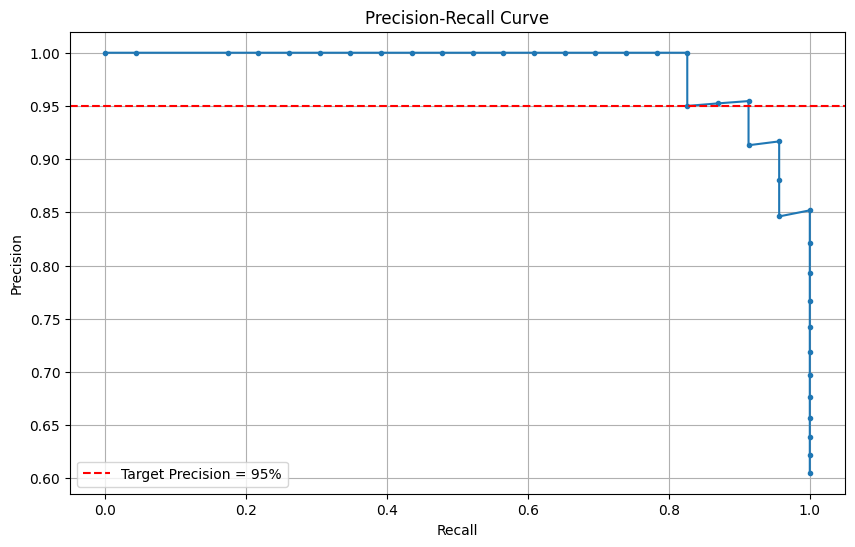

In [12]:
# 7. FIND OPTIMAL THRESHOLD TO MINIMIZE FALSE POSITIVES
# ============================================================

# Get prediction probabilities on validation set
y_val_proba = model.predict_proba(X_val)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

# Find threshold that gives us high precision (low false positives)
# We want precision >= 0.95 (at most 5% false positives)
target_precision = 0.95
optimal_threshold = 0.5  # default

for i, prec in enumerate(precision[:-1]):
    if prec >= target_precision:
        optimal_threshold = thresholds[i]
        optimal_recall = recall[i]
        print(f"\nOptimal Threshold Found: {optimal_threshold:.3f}")
        print(f"  Precision at this threshold: {prec:.3f}")
        print(f"  Recall at this threshold: {optimal_recall:.3f}")
        break

if optimal_threshold == 0.5:
    print(f"\nCouldn't achieve {target_precision:.0%} precision.")
    print("Using default threshold of 0.5")

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.axhline(y=target_precision, color='r', linestyle='--', 
            label=f'Target Precision = {target_precision:.0%}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
# plt.savefig('precision_recall_curve.png')
# print("\nPrecision-Recall curve saved as 'precision_recall_curve.png'")

In [13]:
# 8. EVALUATE MODEL ON VALIDATION SET WITH OPTIMAL THRESHOLD
# ============================================================

# Make predictions using optimal threshold
y_val_pred = (y_val_proba >= optimal_threshold).astype(int)

val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\n{'='*60}")
print(f"VALIDATION SET EVALUATION (Threshold = {optimal_threshold:.3f})")
print(f"{'='*60}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Not Disaster', 'Disaster']))

cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(cm)
print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (correctly predicted non-disasters): {cm[0][0]}")
print(f"  False Positives (incorrectly predicted as disasters): {cm[0][1]}")
print(f"  False Negatives (missed disasters): {cm[1][0]}")
print(f"  True Positives (correctly predicted disasters): {cm[1][1]}")

if cm[0][1] + cm[1][1] > 0:
    precision_val = cm[1][1] / (cm[0][1] + cm[1][1])
    print(f"\n  >>> Precision (% of predicted disasters that are real): {precision_val:.2%}")
    print(f"  >>> False Positive Rate: {cm[0][1] / (cm[0][0] + cm[0][1]):.2%}")

print(f"{'='*60}\n")


VALIDATION SET EVALUATION (Threshold = 0.569)
Validation Accuracy: 0.9211

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.88      0.93      0.90        15
    Disaster       0.95      0.91      0.93        23

    accuracy                           0.92        38
   macro avg       0.91      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38

Confusion Matrix:
[[14  1]
 [ 2 21]]

Confusion Matrix Breakdown:
  True Negatives (correctly predicted non-disasters): 14
  False Positives (incorrectly predicted as disasters): 1
  False Negatives (missed disasters): 2
  True Positives (correctly predicted disasters): 21

  >>> Precision (% of predicted disasters that are real): 95.45%
  >>> False Positive Rate: 6.67%



In [14]:
# 9. TRAIN FINAL MODEL ON FULL TRAINING DATA
# ============================================================

print("Training final model on full training data...")
final_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    C=1.0
)
final_model.fit(X_train, y_train)
print("Final model training complete!")

Training final model on full training data...
Final model training complete!


In [15]:
# 10. MAKE PREDICTIONS ON TEST DATA
# ============================================================

# Predict on English test data with optimal threshold
test_proba = final_model.predict_proba(X_test)[:, 1]
test_english_predictions = (test_proba >= optimal_threshold).astype(int)

# Add predictions to English test dataframe
test_english = test_english.copy()
test_english['predicted_label'] = test_english_predictions
test_english['prediction_confidence'] = test_proba

# Automatically classify non-English tweets as non-disasters
test_non_english = test_non_english.copy()
test_non_english['predicted_label'] = 0  # All non-English = non-disaster
test_non_english['prediction_confidence'] = 0.0  # No confidence score

# Combine English and non-English predictions
all_predictions = pd.concat([test_english, test_non_english], ignore_index=True)
all_predictions = all_predictions.sort_values('id').reset_index(drop=True)

print(f"\nPrediction Summary:")
print(f"  Total tweets: {len(all_predictions)}")
print(f"  English tweets: {len(test_english)}")
print(f"  Non-English tweets (auto-classified as non-disaster): {len(test_non_english)}")
print(f"  Predicted disasters (English only): {sum(test_english_predictions)} ({sum(test_english_predictions)/len(test_english)*100:.1f}% of English tweets)")
print(f"  Total predicted disasters: {sum(all_predictions['predicted_label'])} ({sum(all_predictions['predicted_label'])/len(all_predictions)*100:.1f}% of all tweets)")


Prediction Summary:
  Total tweets: 200
  English tweets: 188
  Non-English tweets (auto-classified as non-disaster): 12
  Predicted disasters (English only): 124 (66.0% of English tweets)
  Total predicted disasters: 124 (62.0% of all tweets)


In [16]:
# 11. EVALUATE ON TEST DATA (IF LABELS ARE AVAILABLE)
# ============================================================

if 'manual_label' in test_df.columns and test_df['manual_label'].notna().any():
    # Merge back with original test_df to get labels
    test_with_labels = test_df[['id', 'manual_label']].merge(
        all_predictions[['id', 'predicted_label']], 
        on='id'
    )
    y_test = test_with_labels['manual_label']
    test_predictions_all = test_with_labels['predicted_label']
    
    test_accuracy = accuracy_score(y_test, test_predictions_all)
    print(f"\n{'='*60}")
    print(f"TEST SET EVALUATION (All tweets)")
    print(f"{'='*60}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, test_predictions_all, target_names=['Not Disaster', 'Disaster']))
    
    cm_test = confusion_matrix(y_test, test_predictions_all)
    print("Confusion Matrix (Test Set):")
    print(cm_test)
    print(f"\nConfusion Matrix Breakdown:")
    print(f"  True Negatives (correctly predicted non-disasters): {cm_test[0][0]}")
    print(f"  False Positives (incorrectly predicted as disasters): {cm_test[0][1]}")
    print(f"  False Negatives (missed disasters): {cm_test[1][0]}")
    print(f"  True Positives (correctly predicted disasters): {cm_test[1][1]}")
    
    if cm_test[0][1] + cm_test[1][1] > 0:
        precision_test = cm_test[1][1] / (cm_test[0][1] + cm_test[1][1])
        print(f"\n  >>> Precision (% of predicted disasters that are real): {precision_test:.2%}")
        print(f"  >>> False Positive Rate: {cm_test[0][1] / (cm_test[0][0] + cm_test[0][1]):.2%}")
    
    # Show breakdown by language
    print(f"\n{'='*60}")
    print("Breakdown by Language:")
    print(f"{'='*60}")
    
    # English tweets evaluation
    test_english_with_labels = test_df[test_df['language'] == 'en'][['id', 'manual_label']].merge(
        test_english[['id', 'predicted_label']], 
        on='id'
    )
    if len(test_english_with_labels) > 0:
        y_test_en = test_english_with_labels['manual_label']
        pred_test_en = test_english_with_labels['predicted_label']
        acc_en = accuracy_score(y_test_en, pred_test_en)
        print(f"English tweets accuracy: {acc_en:.4f} ({len(test_english_with_labels)} tweets)")
    
    # Non-English tweets evaluation
    test_non_english_with_labels = test_df[test_df['language'] != 'en'][['id', 'manual_label']].merge(
        test_non_english[['id', 'predicted_label']], 
        on='id'
    )
    if len(test_non_english_with_labels) > 0:
        y_test_non_en = test_non_english_with_labels['manual_label']
        pred_test_non_en = test_non_english_with_labels['predicted_label']
        acc_non_en = accuracy_score(y_test_non_en, pred_test_non_en)
        print(f"Non-English tweets accuracy: {acc_non_en:.4f} ({len(test_non_english_with_labels)} tweets)")
        print(f"  (Note: All non-English tweets were auto-classified as non-disasters)")
    
    print(f"{'='*60}\n")
else:
    print("\nNote: Test data does not contain labels, skipping evaluation.")


Note: Test data does not contain labels, skipping evaluation.


In [17]:
# 12. CREATE OUTPUT FILE WITH PREDICTIONS
# ============================================================

# Create output dataframe with predictions and probabilities
output_df = all_predictions[['id', 'text', 'language', 'predicted_label', 'prediction_confidence']].copy()

# Save as JSONL
with open('predictions.jsonl', 'w', encoding='utf-8') as f:
    for _, row in output_df.iterrows():
        json_obj = {
            'id': int(row['id']),
            'text': row['text'],
            'language': row['language'],
            'predicted_label': int(row['predicted_label']),
            'prediction_confidence': float(row['prediction_confidence'])
        }
        f.write(json.dumps(json_obj) + '\n')

print("Predictions saved to 'predictions.jsonl'")

# Also save as CSV for easy viewing
output_df.to_csv('predictions.csv', index=False)
print("Predictions also saved to 'predictions.csv'")

# Show sample predictions
print("\nSample predictions (English disasters only):")
disaster_predictions = output_df[(output_df['predicted_label'] == 1) & (output_df['language'] == 'en')].head(3)
for _, row in disaster_predictions.iterrows():
    print(f"\nID: {row['id']}")
    print(f"Language: {row['language']}")
    print(f"Confidence: {row['prediction_confidence']:.3f}")
    print(f"Text: {row['text'][:150]}...")

# Show statistics about non-English tweets
if len(test_non_english) > 0:
    print(f"\n{'='*60}")
    print(f"Non-English tweets (auto-classified as non-disasters):")
    print(f"{'='*60}")
    non_english_langs = test_non_english['language'].value_counts()
    for lang, count in non_english_langs.items():
        print(f"  {lang}: {count} tweets")

Predictions saved to 'predictions.jsonl'
Predictions also saved to 'predictions.csv'

Sample predictions (English disasters only):

ID: 2
Language: en
Confidence: 0.707
Text: New earthquake reported: M 5.4 - Drake Passage - 2025-10-10T22:07:47.232Z...

ID: 7
Language: en
Confidence: 0.707
Text: New earthquake reported: M 5.4 - Drake Passage - 2025-10-10T22:05:28.669Z...

ID: 9
Language: en
Confidence: 0.706
Text: Recent #Earthquake: M 4.9 - Drake Passage reported at 21:13:47 UTC (51 minutes ago). #EarthquakeAlert. 
See more details at https://earthquake.usgs.go...

Non-English tweets (auto-classified as non-disasters):
  ja: 3 tweets
  ko: 3 tweets
  de: 3 tweets
  es: 2 tweets
  fi: 1 tweets


In [18]:
import joblib
import json
import pandas as pd
from datetime import datetime

# ============================================================
# PART 13: SAVING THE MODEL (Add to training notebook)
# ============================================================

def save_model(model, vectorizer, threshold, model_name="disaster_classifier"):
    """
    Save the trained model, vectorizer, and configuration.
    
    Parameters:
    - model: Trained logistic regression model
    - vectorizer: Fitted TF-IDF vectorizer
    - threshold: Optimal threshold for predictions
    - model_name: Base name for saved files
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save model
    model_filename = f"{model_name}_model_{timestamp}.joblib"
    joblib.dump(model, model_filename)
    print(f"Model saved to: {model_filename}")
    
    # Save vectorizer
    vectorizer_filename = f"{model_name}_vectorizer_{timestamp}.joblib"
    joblib.dump(vectorizer, vectorizer_filename)
    print(f"Vectorizer saved to: {vectorizer_filename}")
    
    # Save configuration (threshold and other metadata)
    config = {
        "threshold": threshold,
        "model_file": model_filename,
        "vectorizer_file": vectorizer_filename,
        "created_at": timestamp,
        "model_type": "LogisticRegression"
    }
    
    config_filename = f"{model_name}_config_{timestamp}.json"
    with open(config_filename, 'w') as f:
        json.dump(config, f, indent=2)
    print(f"Configuration saved to: {config_filename}")
    
    return model_filename, vectorizer_filename, config_filename

In [ ]:
model_file, vectorizer_file, config_file = save_model(
    model=final_model,
    vectorizer=tfidf,
    threshold=optimal_threshold,
    model_name="bluesky_classifier"
)

Model saved to: bluesky_disaster_classifier_model_20251010_225814.joblib
Vectorizer saved to: bluesky_disaster_classifier_vectorizer_20251010_225814.joblib
Configuration saved to: bluesky_disaster_classifier_config_20251010_225814.json
